In [1]:
import gym
import torch
import gym_nav
import numpy as np

In [90]:
env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True, 
              'turn_speed': 0.5, 'move_speed': 15, 'max_steps': 500}
env = gym.make('NavEnv-v0', **env_kwargs)

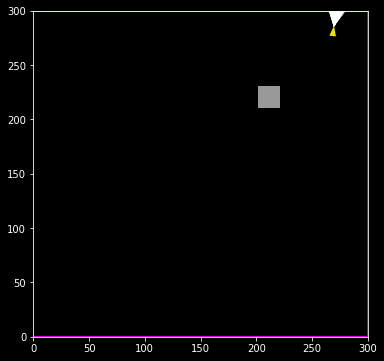

In [56]:
obs = env.reset()
env.render('human')

-0.6856505705034888


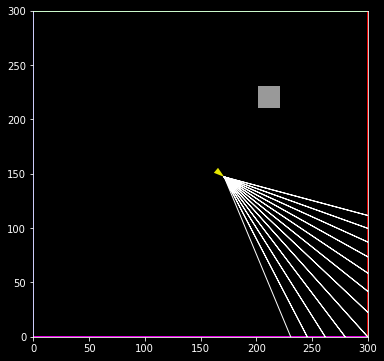

-0.6856505705034888


In [89]:
print(env.character.angle)
obs = env.step(1)
env.render('human')
print(env.character.angle)

In [2]:
from read_experiments import *

In [44]:

average_runs()

<function read_experiments.average_runs(trial_name, metric='return', ax=None, ret=False, ewm=0.01, label=None, cloud_alpha=0.1, cloud_by='minmax', ignore_first=16, color=None, medians=False, div_x_by_mil=False, ls=None, verbose=False, ignore_trial_idxs=[], skip_indexing=1)>

In [27]:
import sys
sys.path.append('../')
from evaluation import *
from model_evaluation import *
from trajectories import *
%run ../evaluation 

env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True}

env_kwargs = {'num_objects': 0, 'rew_structure': 'explore',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True,
              'turn_speed': 0.5, 'move_speed': 10, 'max_steps': 500}

env_kwargs = {'num_objects': 0, 'rew_structure': 'explorepunish', 'sub_goal_reward': 0.02,
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True,
              'turn_speed': 0.5, 'move_speed': 10, 'max_steps': 500}

# model, obs_rms = torch.load('../trained_models/ppo/nav_4wallexplore/nav_4wallexplore_batch128onehot_t0.pt')
# model, obs_rms = torch.load('../saved_models/4wallexplore/nav_4wallexplore_batch128faster20m_t1.pt')
# model, obs_rms = torch.load('../saved_models/4we_aux/nav_4wallexplore_batch128faster20mrewexplore_t0.pt')
# model, obs_rms = torch.load('../saved_models/4we_aux/nav_4wallexplore_batch128explorepunish_t0.pt')
model, obs_rms = torch.load('../saved_models/4we_punish/nav_4wallexplore_ep0.1_t2.pt')

res = evaluate(model, obs_rms, env_kwargs=env_kwargs, num_episodes=5, data_callback=nav_data_callback,
              verbose=2)

C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ep 0, rew tensor([[-4.4069]])
ep 1, rew tensor([[-2.3579]])
ep 2, rew tensor([[2.9279]])
ep 3, rew tensor([[-7.1225]])
ep 4, rew tensor([[-0.3226]])
 Evaluation using 0 episodes: mean reward nan



C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\14and\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# !!Check whether episodes where goal is found and refound the RNN hidden state looks different. Or check whether receiving the goal reached observation makes significant change in RNN

(Figure(nrows=1, ncols=1, refwidth=2.5),
 SubplotGrid(nrows=1, ncols=1, length=1))

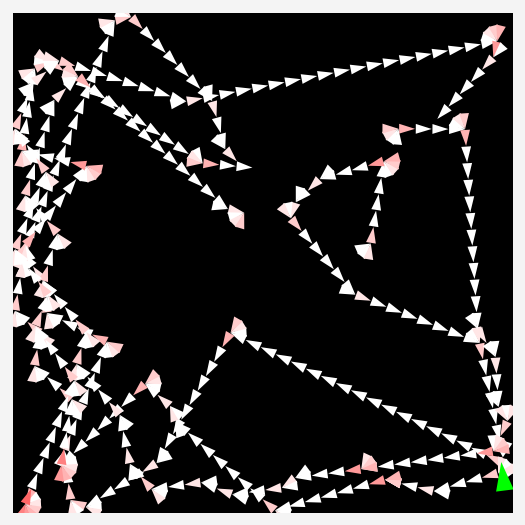

In [28]:
i = 2

pos = res['data']['pos'][i]
angle = res['data']['angle'][i]

draw_trajectory(pos, angle)

In [30]:
envs = simple_vec_envs(obs_rms, env_kwargs=env_kwargs)

In [31]:
res = evaluate_steps(model, envs, num_steps=100, data_callback=nav_data_callback)

In [33]:
env = envs.envs[0]
env.visited_positions

array([[239.23651845,  97.09652654],
       [239.23651845,  97.09652654],
       [229.81684411, 100.45356917],
       ...,
       [         inf,          inf],
       [         inf,          inf],
       [         inf,          inf]])

In [38]:
visited_distanced = np.full((env.visited_positions.shape[0]), False)

In [39]:
env.visited_positions[visited_distanced]

array([], shape=(0, 2), dtype=float64)

In [43]:
infs = (env.visited_positions == np.inf).all(axis=1)
check_pos = env.visited_positions[~visited_distanced & ~infs]

In [46]:
pos = env.character.pos
check_dists = np.sqrt(np.sum((check_pos - pos)**2, axis=1))

In [22]:
pos = env.character.pos
env.visited_positions[env.visited_idx] = pos.copy()
env.visited_idx += 1

lim_idx = int(np.clip(env.visited_idx-10, 0, np.inf))

if lim_idx > 0:
    dists = env.visited_positions[:lim_idx] - pos
    dist = np.min(np.sum(dists**2, axis=1))
    dist = np.sqrt(dist)

    # This pretty much goes to 0 around dist of 50, which is tuned
    #  to a move speed of 10
    punish = -np.exp(-dist/10) * env.sub_goal_reward


# Explore punish

In [2]:
env_kwargs = {'num_objects': 0, 'rew_structure': 'explorepunish',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True,
              'turn_speed': 0.5, 'move_speed': 10, 'max_steps': 500}
env_kwargs = {'num_objects': 0, 'rew_structure': 'explorepunish2',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True,
              'turn_speed': 0.5, 'move_speed': 10, 'max_steps': 500}

In [3]:
env = gym.make('NavEnv-v0', **env_kwargs)
env.reset()
# 

array([0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.08629932, 0.08733791, 0.08902

In [4]:
env.visited_positions

array([[inf, inf],
       [inf, inf],
       [inf, inf],
       ...,
       [inf, inf],
       [inf, inf],
       [inf, inf]])

(array([0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.33804005, 0.28171735, 0.2429

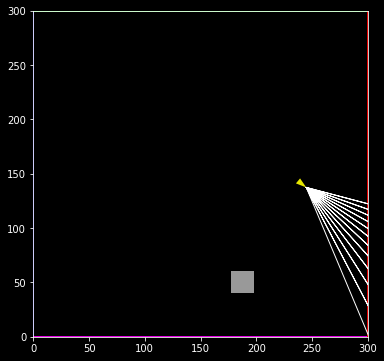

In [29]:
print(env.step(1))
env.render('human')

# Test shortcut env

In [21]:
env = gym.make('ShortcutNav-v0', shortcut_probability=0.5)

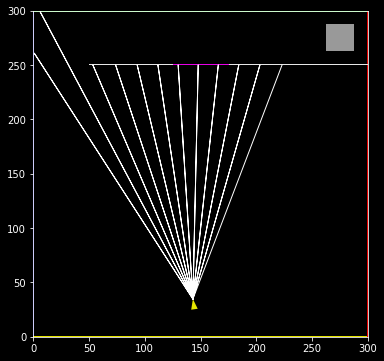

In [30]:

env.reset()
env.render('human')

In [5]:
env.character.ray_dists

array([264.05469338, 273.8630102 , 259.0769037 , 247.43497454,
       238.37763417, 231.51000444, 226.55536371, 223.32585207,
       221.70421464, 221.63309706, 223.11000717, 226.18709902])

In [8]:
char = env.character


In [9]:
fov_start = char.angle - char.fov/2
fov_end = fov_start + char.fov

ray_angles = np.linspace(fov_start, fov_end, char.num_rays, endpoint=False)
ray_mults = np.array([np.cos(ray_angles), np.sin(ray_angles)]).T
ray_ends = ray_mults * char.ray_max_len + char.pos
ray_starts = np.full((char.num_rays, 2), char.pos)

x1 = ray_starts[:, 0].reshape(-1, 1)
y1 = ray_starts[:, 1].reshape(-1, 1)
x2 = ray_ends[:, 0].reshape(-1, 1)
y2 = ray_ends[:, 1].reshape(-1, 1)

#Compute intersect metrics
epsilon = 1e-8
denom = (char.y4-char.y3)*(x2-x1) - (char.x4-char.x3)*(y2-y1) + 1e-8
ua = ((char.x4-char.x3)*(y1-char.y3) - (char.y4-char.y3)*(x1-char.x3)) / denom
ub = ((x2-x1)*(y1-char.y3) - (y2-y1)*(x1-char.x3)) / denom

#Compute x y intersects (they ARE both supposed to be ua)
x = x1 + ua*(x2-x1)
y = y1 + ua*(y2-y1)

#Compute distances to intersects
dists = np.sqrt((x - char.pos[0])**2 + (y - char.pos[1])**2)

#Only keep distances with valid intersects
mults = np.full(x.shape, 1.)
mults[((ua < 0) | (ua > 1) | (ub < 0) | (ub > 1))] = np.inf

#We get np.nan where lines are parallel which throws off the argmin
# Setting parallel to inf should fix the issue
dists[np.isnan(dists)] = np.inf

wall_idxs = np.argmin(mults*dists, axis=1)
wall_idxs2 = np.stack([np.arange(char.num_rays), wall_idxs])

# inter_x = x[wall_idxs2[0], wall_idxs2[1]]
# inter_y = y[wall_idxs2[0], wall_idxs2[1]]


In [11]:
ray_dists = dists[wall_idxs2[0], wall_idxs2[1]]
ray_colors = list(map(lambda x: x.color, char.vis_wall_refs[wall_idxs]))


# Behavior in shortcut

In [31]:
import sys
sys.path.append('../')
from model_evaluation import *
from trajectories import *
from evaluation import *

model, obs_rms = torch.load('../saved_models/shortcuts/shortcutnav_shortcutprob0batch32_t0.pt')

res = evaluate(model, obs_rms, num_episodes=5, data_callback=nav_data_callback,
              verbose=2, env_name='ShortcutNav-v0')

C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ep 0, rew tensor([[1.]])
ep 1, rew tensor([[1.]])
ep 2, rew tensor([[1.]])
ep 3, rew tensor([[1.]])
ep 4, rew tensor([[1.]])
 Evaluation using 0 episodes: mean reward nan



C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\14and\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
%run gradients

In [45]:
agent, envs, rollouts = initialize_ppo_training(model, obs_rms, 'ShortcutNav-v0', num_steps=100)
actor_critic = agent.actor_critic
res = populate_rollouts_aux(actor_critic, envs, rollouts)

In [46]:
with torch.no_grad():
    next_value = actor_critic.get_value(
        rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
        rollouts.masks[-1]).detach()

In [53]:
returns = rollouts.returns.clone()

In [55]:
returns[-1] = next_value

In [58]:
gamma = 0.99

In [59]:
for step in reversed(range(rollouts.rewards.size(0))):
    returns[step] = returns[step + 1] * gamma * rollouts.masks[step + 1] + rollouts.rewards[step]

In [61]:
returns - rollouts.value_preds

tensor([[[-1.4728e+00]],

        [[-1.3939e+00]],

        [[-1.4034e+00]],

        [[-1.4505e+00]],

        [[-1.4448e+00]],

        [[-1.4498e+00]],

        [[-1.4351e+00]],

        [[-1.4409e+00]],

        [[-1.4359e+00]],

        [[-1.5344e+00]],

        [[-1.5561e+00]],

        [[-1.5862e+00]],

        [[-1.5947e+00]],

        [[-1.5954e+00]],

        [[-1.6011e+00]],

        [[-1.6445e+00]],

        [[-1.6479e+00]],

        [[-1.6522e+00]],

        [[-1.6573e+00]],

        [[-1.6639e+00]],

        [[-1.6728e+00]],

        [[-1.7053e+00]],

        [[-1.7251e+00]],

        [[-1.7237e+00]],

        [[-1.7288e+00]],

        [[-1.7510e+00]],

        [[-1.7636e+00]],

        [[-1.7606e+00]],

        [[-1.8741e+00]],

        [[-1.8892e+00]],

        [[-1.9400e+00]],

        [[-1.8641e+00]],

        [[-1.8548e+00]],

        [[-1.8939e+00]],

        [[-1.9334e+00]],

        [[-1.9595e+00]],

        [[-1.9773e+00]],

        [[-1.9851e+00]],

        [[-2

(Figure(nrows=1, ncols=1, refwidth=2.5),
 SubplotGrid(nrows=1, ncols=1, length=1))

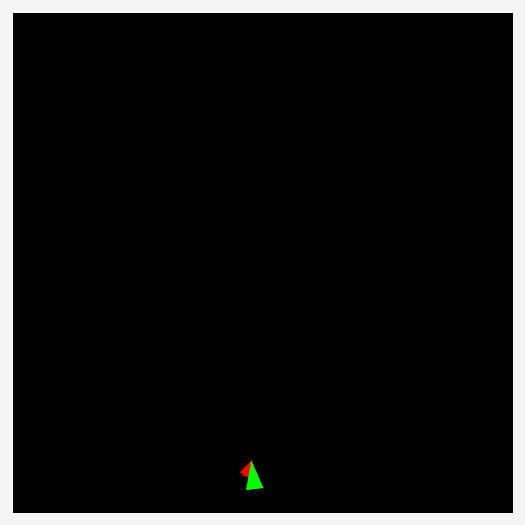

In [21]:
i = 0

pos = res['data']['pos'][i]
angle = res['data']['angle'][i]

draw_trajectory(pos, angle)
